## Libraries and data import

In [72]:
import pandas as pd
import numpy as np
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import multiprocessing

In [49]:
calib = pd.read_excel('tweets_train_hourly.xls')
predict = pd.read_excel('tweets_test_hourly.xls')

## Some exploration before deepdive

In [66]:
calib.head()
#calib.shape


,text,get_close_price,get_open_price,Open,Close,is_up,diff,absdiff
0,the fact that sneaky dianne feinstein who has ...,2018-01-10 15:30:00+00:00,2018-01-10 14:30:00+00:00,2743.780029,2745.199951,1,1.419922,1.419922
1,i want to thank my cabinet for working tireles...,2018-01-10 20:30:00+00:00,2018-01-10 19:30:00+00:00,2744.260010,2748.399902,1,4.139893,4.139893
2,great news as a result of our tax cuts jobs act,2018-01-11 15:30:00+00:00,2018-01-11 14:30:00+00:00,2753.959961,2757.239990,1,3.280029,3.280029
3,today it was my great honor to proclaim januar...,2018-01-12 17:30:00+00:00,2018-01-12 16:30:00+00:00,2780.489990,2781.969971,1,1.479980,1.479980
4,president donald j trump proclaims january 16 ...,2018-01-16 19:30:00+00:00,2018-01-16 18:30:00+00:00,2790.080078,2781.530029,0,-8.550049,8.550049


In [52]:
# How many words are there in the corpus? 

print(calib['text'].apply(lambda x: len(x.split(' '))).sum)

<bound method Series.sum of 0       87
1       41
2       13
3       42
4       13
      ... 
633     28
634     45
635    116
636    119
637    190
Name: text, Length: 638, dtype: int64>


In [53]:
# Creating an absolute difference feature

calib['absdiff'] = np.abs(calib['diff'])
impact_sorted = calib.sort_values(by=['absdiff'])

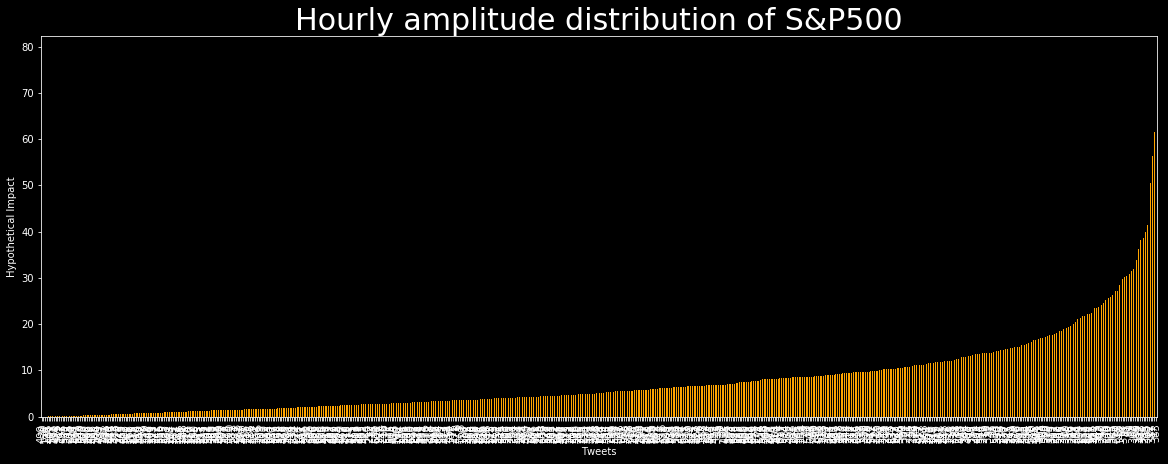

In [54]:
# Vizualizing the impact of certain tweets in the hour time window.

plt.style.use('dark_background')
impact_sorted['absdiff'].plot.bar(color = 'orange', figsize = (20, 7))
plt.title('Hourly amplitude distribution of S&P500', fontsize = 30, fontweight = 20)
plt.xlabel('Tweets')
plt.ylabel('Hypothetical Impact')
plt.show()

In [56]:
# In case we want to create a third class called 'Hold' to take out stationarity.
# This is in line with the basic three-way trading strategy: buy, hold or sell.

#large_impact = calib['absdiff'] < 2
#impact_tweets = calib[large_impact]
#impact_tweets.shape

In [63]:
# Minimum cleaning because we want the network to pick up on weak signals

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,}',r'',text)
    text = re.sub(r'[^\w\s]', r'',text)
    text = text.lower()
    return text
calib['text'] = calib['text'].apply(cleanText)

In [64]:
calib['text']

0      the fact that sneaky dianne feinstein who has ...
1      i want to thank my cabinet for working tireles...
2      great news as a result of our tax cuts  jobs act 
3      today it was my great honor to proclaim januar...
4      president donald j trump proclaims january 16 ...
                             ...                        
633    it is the 25th anniversary of a great organiza...
634    great reception in jamestown by both republica...
635    such a great victory in court yesterday on the...
636    lowering drug prices for many americans  inclu...
637    the prosecutors who lost the case against seal...
Name: text, Length: 638, dtype: object

In [69]:
# Train and test split on calibration set

train, test = train_test_split(calib, test_size=0.3, random_state=42)

In [70]:
# Removing stopwords using NLTK library and tagging every tweet with its is_up feature

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.is_up]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.is_up]), axis=1)

In [71]:
train_tagged.values[30]

TaggedDocument(words=['china', 'is', 'actually', 'placing', 'propaganda', 'ads', 'in', 'the', 'des', 'moines', 'register', 'and', 'other', 'papers', 'made', 'to', 'look', 'like', 'news', 'thats', 'because', 'we', 'are', 'beating', 'them', 'on', 'trade', 'opening', 'markets', 'and', 'the', 'farmers', 'will', 'make', 'fortune', 'when', 'this', 'is', 'over', 'congressman', 'lee', 'zeldin', 'is', 'doing', 'fantastic', 'job', 'in', 'dc', 'tough', 'and', 'smart', 'he', 'loves', 'our', 'country', 'and', 'will', 'always', 'be', 'there', 'to', 'do', 'the', 'right', 'thing', 'he', 'has', 'my', 'complete', 'and', 'total', 'endorsement'], tags=[1])

## tweet2vec Implementation

   ## Embedding 1: Distributed Bag-Of-Words (DBOW)

In [73]:
# Parallel computation

cores = multiprocessing.cpu_count()

In [74]:
# DBOW is the doc2vec model analogous to Skip-gram model in word2vec. Here, the tweet vectors are 
# obtained by training a neural network on the task of predicting a probability distribution of words 
# in a tweet given a randomly-sampled word from the tweet.

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in train_tagged.values])

In [75]:
# Training for 30 epochs

%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 446/446 [00:00<00:00, 934862.36it/s]


CPU times: user 2.27 s, sys: 220 ms, total: 2.49 s
Wall time: 1.79 s


In [77]:
# Building the final vector feature for the classifier

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [78]:
# Training a logistic regression classifier on the tweet embeddings

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.4583333333333333
Testing F1 score: 0.45691721132897606


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Embedding 2: Distributed Memory (DM)

In [79]:
#Distributed Memory (DM) acts as a memory that remembers what is missing from the current context
# — or as the topic of the paragraph. While the word vectors represent the concept of a word, the 
#tweet vector intends to represent the concept of a tweet. 

model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 446/446 [00:00<00:00, 357337.07it/s]


In [80]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 446/446 [00:00<00:00, 711277.41it/s]


CPU times: user 3.91 s, sys: 251 ms, total: 4.16 s
Wall time: 2.63 s


In [81]:
# Training the logistic on DM features

y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.4895833333333333
Testing F1 score: 0.48690632284382285


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Model pairing: combining DBOW and DM

In [82]:
# Delete previous training to free up RAM space

model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [85]:
# Concatenate DBOW and DM embeddings

from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [86]:
# Building feature vectors

def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [87]:
# Train the logistic classifier 

y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5520833333333334
Testing F1 score: 0.5472077148616455


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [88]:
# Concatenating the two models improved the accuracy by 6% but this is still not enough.
# Steps for improvement: 
    # Train the embeddings on the whole calibration set, not only train. 
    # Use another classification model than logistic. 
    # Add the 'Hold' class to potentially improve lift score, 
        # even if adding a third class is conditionned to having more data. 